# **Figure ?.** Diffusion Coefficient
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 01/31/2022          |
| Updated | 08/11/2022          |

## $D$, $H_\mathrm{p}$ vs. $\Pi$
See Yang et al. (2009), § 4.1, for CC's derivation of the diffusion coefficient, $D$.

From Eq. 9 of Yang & Zhu (2021),
\begin{equation}
  H_\mathrm{p} \approx \sqrt{\frac{D_z}{\Omega_\mathrm{K}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)} = H_\mathrm{g}\sqrt{\frac{D_z}{c_\mathrm{s}H_\mathrm{g}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)},
\end{equation}
where $(\tau_\mathrm{s} + \tau_\mathrm{s}^{-1})/\Omega_\mathrm{K}$ is the sedimentation time-scale (Youdin & Lithwick 2007).

### $H_\mathrm{p}$ plot?
  - https://www.geeksforgeeks.org/matplotlib-pyplot-twinx-in-python/

,Case,Function,a,±𝜎ₐ,k,±𝜎ₖ
0,AB,𝐷_z = aΠᵏ,2.1e-01,±5.8e-03,1.8e+00,±1.2e-02
1,AB,𝐷_x = aΠᵏ,5.7e-01,±2.9e-02,2.0e+00,±2.2e-02
2,BA,𝐷_z = aΠᵏ,7.8e-01,±3.1e-01,5.8e-01,±1.4e-01
3,BA,𝐷_x = aΠᵏ,1.9e+00,±3.4e-01,1.2e+00,±7.2e-02


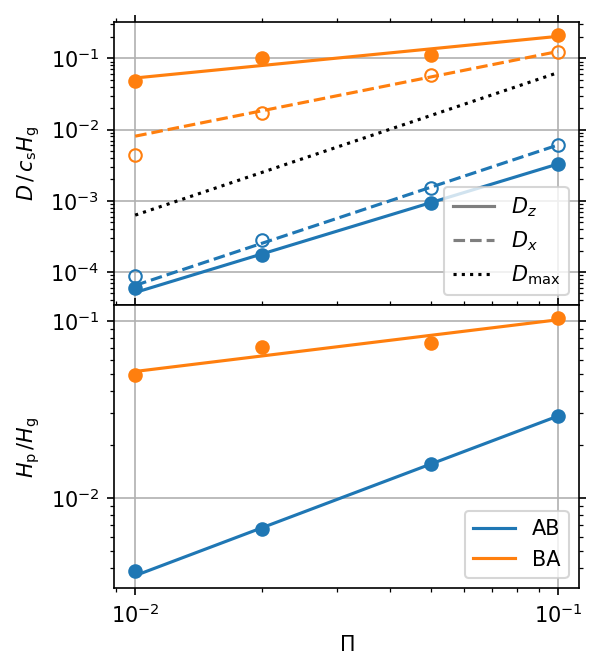

In [27]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

workdir = '../unstrat'
cases = [['AB', 'tab:blue'], ['BA', 'tab:orange']]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
dirs = [['z', 'dpy', 'full', 'solid'],
        ['x', 'dpx', 'none', 'dashed']]
Ds, Hps = np.zeros((len(Pis), len(dirs))), np.zeros(len(Pis))
plaw = lambda Pi, a, k : a*Pi**k # Power-law model function
Hp = lambda D_z, c_s, Hg, tau_s: np.sqrt(D_z*(tau_s + 1/tau_s)/c_s/Hg)
group, modplaw, a, aerr, k, kerr = [], [], [], [], [], []
xfit = np.linspace(0.01, 0.1)
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(4, 5), dpi=150)

for case in cases:
    axs[1].plot([], [], color=case[1], label=case[0])

    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            # Collect sim parameters, diffusion coefficients, dust scale heights
            path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            c_s = athinput['hydro']['iso_sound_speed']
            Omega = athinput['problem']['omega']
            Hg = c_s/Omega
            tau_s= athinput['particles']['taus0']*Omega
            if case[0] == 'AB' and Pi == 0.01: D = np.load(f'{path}/output/dcoeff-61.npz')
            else: D = np.load(f'{path}/output/dcoeff-81.npz')
            Ds[j, i] = 2*np.pi*D[dir[1]][0] # convert from [Hg**2/T] to [c_s*Hg]
            if dir[0] == 'z': Hps[j] = Hp(D[dir[1]][0], c_s, Hg, tau_s)

        # Best-fit and plot diffusion coefficients
        popt, pcov = curve_fit(plaw, Pis, Ds[:, i])
        perr = np.sqrt(np.diag(pcov))
        yfit = plaw(xfit, *popt)
        axs[0].plot(Pis, Ds[:, i], marker='o', ls='none', color=case[1], fillstyle=dir[2])
        axs[0].plot(xfit, yfit, ls=dir[3], color=case[1])
        group.append(case[0]); modplaw.append(f'𝐷_{dir[0]} = aΠᵏ')
        a.append(popt[0]); aerr.append(perr[0])
        k.append(popt[1]); kerr.append(perr[1])

        # Plot dust scale heights
        if dir[0] == 'z':
            axs[1].plot(Pis, Hps, marker='o', ls='none', color=case[1], fillstyle=dir[2])
            axs[1].plot(xfit, Hp(yfit/2/np.pi, c_s, Hg, tau_s), ls=dir[3], color=case[1])

# Plot Dmax, add legend keys, and format subplots
for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True)

axs[0].plot([], [], ls=dirs[0][3], color='tab:gray', label=f'$D_{dirs[0][0]}$')
axs[0].plot([], [], ls=dirs[1][3], color='tab:gray', label=f'$D_{dirs[1][0]}$')
axs[0].plot(xfit, plaw(xfit, 2*np.pi, 2), ls=':', color='black',
            label=r'$D_\mathrm{max}$')# = 2\pi\Pi^2$')
axs[0].legend()
axs[0].set(ylabel=r'$D\,/\,c_\mathrm{s}H_\mathrm{g}$', xscale='log',
           yscale='log',)# ylim=(5e-7, 2e-2))
axs[1].legend()
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$H_\mathrm{p}\,/H_\mathrm{g}$',
           xscale='log', yscale='log',)# xlim=(8e-3, 0.13))

fig.subplots_adjust(hspace=0)
# plt.savefig('figs/Ds.pdf', bbox_inches='tight', pad_inches=0.01)-

df = pd.DataFrame({
    'Case'     : group,
    'Function' : modplaw,
    'a'        : a,
    '±𝜎ₐ'      : aerr,
    'k'        : k,
    '±𝜎ₖ'      : kerr,})
s = df.style.format({
    'a'   : '{:.1e}',
    '±𝜎ₐ' : '±{:.1e}',
    'k'   : '{:.1e}',
    '±𝜎ₖ' : '±{:.1e}',})
s.to_latex(buf='tabs/Ds.txt')
s

,Case,Function,a,±𝜎ₐ,k,±𝜎ₖ
0,AB,𝐷_z = aΠᵏ,3.3e-02,±9.2e-04,1.8e+00,±1.2e-02
1,AB,𝐷_x = aΠᵏ,9.0e-02,±4.6e-03,2.0e+00,±2.2e-02
2,BA,𝐷_z = aΠᵏ,1.2e-01,±5.0e-02,5.8e-01,±1.4e-01
3,BA,𝐷_x = aΠᵏ,3.1e-01,±5.4e-02,1.2e+00,±7.2e-02


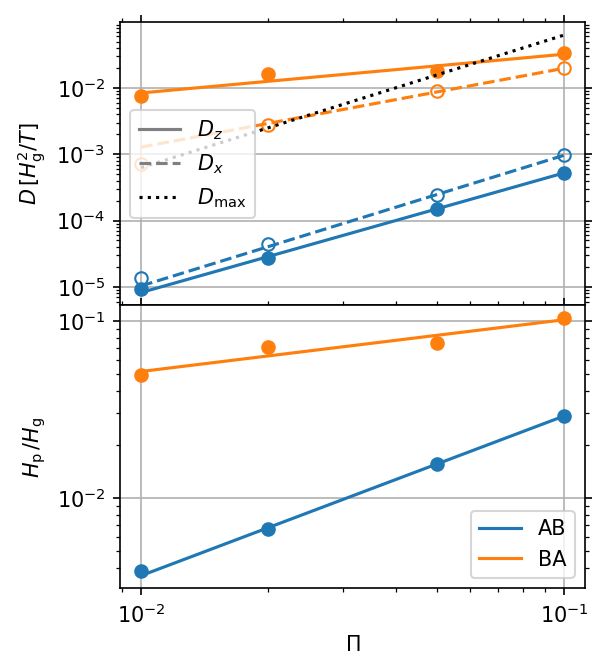

In [29]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

workdir = '../unstrat'
cases = [['AB', 'tab:blue'], ['BA', 'tab:orange']]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
dirs = [['z', 'dpy', 'full', 'solid'],
        ['x', 'dpx', 'none', 'dashed']]
Ds, Hps = np.zeros((len(Pis), len(dirs))), np.zeros(len(Pis))
plaw = lambda Pi, a, k : a*Pi**k # Power-law model function
Hp = lambda D_z, c_s, Hg, tau_s: np.sqrt(D_z*(tau_s + 1/tau_s)/c_s/Hg)
group, modplaw, a, aerr, k, kerr = [], [], [], [], [], []
xfit = np.linspace(0.01, 0.1)
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(4, 5), dpi=150)

for case in cases:
    axs[1].plot([], [], color=case[1], label=case[0])

    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            # Collect sim parameters, diffusion coefficients, dust scale heights
            path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            c_s = athinput['hydro']['iso_sound_speed']
            Omega = athinput['problem']['omega']
            Hg = c_s/Omega
            tau_s= athinput['particles']['taus0']*Omega
            if case[0] == 'AB' and Pi == 0.01: D = np.load(f'{path}/output/dcoeff-61.npz')
            else: D = np.load(f'{path}/output/dcoeff-81.npz')
            Ds[j, i] = D[dir[1]][0] # keep in [Hg**2/T]
            if dir[0] == 'z': Hps[j] = Hp(D[dir[1]][0], c_s, Hg, tau_s)

        # Best-fit and plot diffusion coefficients
        popt, pcov = curve_fit(plaw, Pis, Ds[:, i])
        perr = np.sqrt(np.diag(pcov))
        yfit = plaw(xfit, *popt)
        axs[0].plot(Pis, Ds[:, i], marker='o', ls='none', color=case[1], fillstyle=dir[2])
        axs[0].plot(xfit, yfit, ls=dir[3], color=case[1])
        group.append(case[0]); modplaw.append(f'𝐷_{dir[0]} = aΠᵏ')
        a.append(popt[0]); aerr.append(perr[0])
        k.append(popt[1]); kerr.append(perr[1])

        # Plot dust scale heights
        if dir[0] == 'z':
            axs[1].plot(Pis, Hps, marker='o', ls='none', color=case[1], fillstyle=dir[2])
            axs[1].plot(xfit, Hp(yfit, c_s, Hg, tau_s), ls=dir[3], color=case[1])

# Plot Dmax, add legend keys, and format subplots
for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True)

axs[0].plot([], [], ls=dirs[0][3], color='tab:gray', label=f'$D_{dirs[0][0]}$')
axs[0].plot([], [], ls=dirs[1][3], color='tab:gray', label=f'$D_{dirs[1][0]}$')
axs[0].plot(xfit, plaw(xfit, 2*np.pi, 2), ls=':', color='black',
            label=r'$D_\mathrm{max}$')# = 2\pi\Pi^2$')
axs[0].legend()
axs[0].set(ylabel=r'$D\,[H_\mathrm{g}^2/T]$', xscale='log',
           yscale='log',)# ylim=(5e-7, 2e-2))
axs[1].legend()
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$H_\mathrm{p}\,/H_\mathrm{g}$',
           xscale='log', yscale='log',)# xlim=(8e-3, 0.13))

fig.subplots_adjust(hspace=0)
# plt.savefig('figs/Ds.pdf', bbox_inches='tight', pad_inches=0.01)-

df = pd.DataFrame({
    'Case'     : group,
    'Function' : modplaw,
    'a'        : a,
    '±𝜎ₐ'      : aerr,
    'k'        : k,
    '±𝜎ₖ'      : kerr,})
s = df.style.format({
    'a'   : '{:.1e}',
    '±𝜎ₐ' : '±{:.1e}',
    'k'   : '{:.1e}',
    '±𝜎ₖ' : '±{:.1e}',})
s.to_latex(buf='tabs/Ds.txt')
s